### 回归 VS 分类

* 给定训练样本集$\{(\mathbf{x_1},y_1),\cdots,(\mathbf{x_N},y_N)\},\mathbf{x_i}∈\mathbb{R}^d$
    
    - 回归：预测的是连续值
    - 分类：预测的是离散值
        - 二分类：$y_i∈\{0,1\}$

In [1]:
# 说明：为什么不能使用线性回归+阈值来预测分类？
# 线性回归不是不能预测分类，在简单的模型中也可用于分类，但是有些模型使用线性模型+阈值的方法就会出现误分类
# 在SVM中，线性可分的情况下，就是使用的线性模型来分类的，加入了软/硬间隔
# 由此，我们对线性回归进行了改造，套用Sigmod函数这个压缩函数，将其以0-1的概率输出，并以0.5的概率作为正负样本1\0的分界点实现分类
# 关于逻辑回归的总结：https://www.cnblogs.com/pinard/p/6029432.html

### Sigmoid函数

* 线性回归的预测函数：$y = \mathbf{w^Tx} + b = \mathbf{\bar{w}X}$

* 我们要使用分段函数实现如下的映射，也就能实现分类：
$$z = 
\begin{cases}
    0 & y<0 \\
    0.5 & y=0 \\
    1 & y>0 
\end{cases}$$

* 但是分段函数不可导，就想到套用sigmod函数：
$$z = \frac{1}{1+e^{-y}}$$

([<matplotlib.axis.YTick at 0x11147bf98>,
 <a list of 3 Text yticklabel objects>)

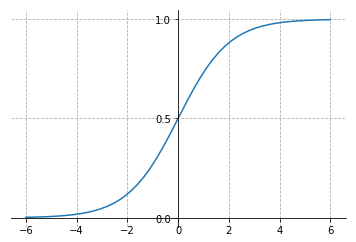

In [2]:
# sigmod函数

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-6,6)
y = x
z = 1/(1+np.exp(-y))

plt.plot(y,z)
ax = plt.gca()
ax.spines['bottom'].set_position(('data', 0))
ax.spines['left'].set_position(('data',0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(linestyle='dashed')
plt.yticks([0,0.5,1])

In [3]:
# 说明：因很多地方都有用到sigmod这样的激活函数，比如逻辑回归、神经网络等，当然激活函数不止sigmod一种
# 也就是说我们会涉及到对sigmod函数的求导，这边我们来推导下这个过程

#### S函数求导

* $\sigma(x) = \large\frac{1}{1+e^{-x}}$
* $\frac{d\sigma(x)}{dx} = \sigma(x) - \sigma(x)^2$

令$u=1+e^{-x}$，则有：
$\frac{d\sigma(x)}{dx} = \frac{d\sigma(x)}{du}\frac{du}{dx}$

而$\frac{d\sigma(x)}{du} = \left(\frac{1}{u}\right)' = -\frac{1}{u^2} = -\frac{1}{(1+e^{-x})^2}$，$\frac{du}{dx} = -e^{-x}$

继而有$\frac{d\sigma(x)}{dx} = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1+e^{-x}-1}{(1+e^{-x})^2} = \sigma(x) - \sigma(x)^2$

In [4]:
# 神经网络
# 所谓神经网络，因其架构类似人类神经网络连接，也是连接的神经节点越多，能力也就越强
# 神经网络特别适合用于分类，如图像的识别，人脸识别等
# 这边说的神经网络指的是前馈神经网络，节点与节点之间没有联系，只与前面的节点有联系
# 我们把每个神经节点称为神经元，在隐藏层，每经过一个节点，就会嵌套一个激活函数，这个激活函数的输出值作为下一次的输入值，相互嵌套
# 比如在处理这些非线性分类、螺旋式分类，效率就显得特别快，而使用传统的逻辑回归需要高次函数来实现分隔，计算量大大增加
# 神经网络里采用逻辑与AND、逻辑或OR、逻辑非和逻辑异或进行空间切分的 比如先逻辑与，再逻辑或
# 神经网络的每个输出就相当于逻辑与的一次空间划分
# 典型的神经网络分为输入层、隐层和输出层，一般隐层会很很多层，视情况而定
# 常见的神经网络架构图如下：

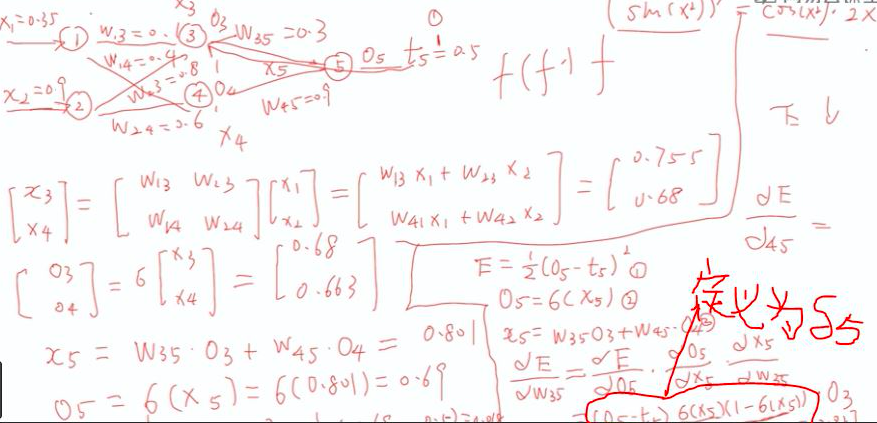

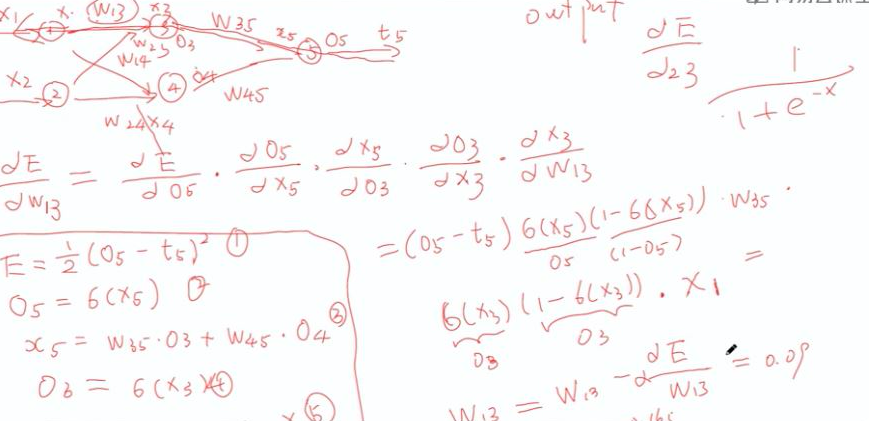

In [5]:
# BP算法
# 1、输入值一般来自数据本身
# 2、首次，我们需要定义层与层之间每个神经元连接的权重
# 3、由此，沿着每条链路直到输出值，这个过程是正向传播过程
# 4、因我们的目标是要优化最终输出值与真实值之间的差距，第一次假定权重输出的结果值肯定与真实值之间差距较大，
# 由此想到的就是不断迭代优化这些权重，也就是分别对每个权重系数求偏导，直到差距满足一定条件停止迭代
# 5、这边的损失误差还是使用的最小二乘，只不过经过每个节点都嵌套了激活函数sigmod(其它函数也可)
# 6、经过多次正向传播和反向传播，以此确定模型的最佳权重系数
# BP算法之反向传播，其实就是对偏导的链式法则的运用，整个过程其实并不复杂，关键要搞清楚符号之间的关系
# 一般使用梯度下降迭代法，也可以使用牛顿法和拟牛顿法取加快迭代速度

In [6]:
# BP在各个书籍文献论文中常有不同的表示方式，现对BP算法数学描述符号进行总结

#### 符号定义

* $x_j^l$：层$l$下的节点$j$的输入
* $w_{i,j}^l$：从层$l-1$中的几点$i$到层$l$中的节点$j$这一段的权重
* $\sigma(x) = \large\frac{1}{1+e^{-x}}$
* $θ_j^l$：层$l$下的节点$j$的偏置
* $O_j^l$：层$l$下的节点$j$的输出
* $t_j$：目标值
* $E=\frac{1}{2}\sum_{k∈K}(O_k-t_k)^2$

In [7]:
# BP算法中的输出层和隐层求导稍有些不同，我们来对其进行归纳总结

### BP(输出层)

* 目标是计算：$\large\frac{\partial{E}}{\partial{w_{j,k}}}$

* 具体计算

$$\begin{align*}
    \frac{\partial{E}}{\partial{w_{j,k}}} &= \frac{\partial}{\partial{O_k}}\frac{1}{2}\sum\limits_{k∈K}(O_k-t_k)^2 \times \frac{\partial}{\partial{x_k}}O_k \times \frac{\partial}{\partial{w_{j,k}}}x_k \\
&   = (O_k - t_k) \times \frac{\partial}{\partial{x_k}}\sigma(x_k) \times O_j \\
&   = (O_k - t_k) \times \sigma(x_k)(1- \sigma(x_k)) \times O_j \\
&   = \underbrace{(O_k - t_k)O_k(1- O_k)}_{δ_k} \times O_j 
\end{align*}$$

* 上下括号例子：
$\begin{equation}
  \underbrace{a + \overbrace{b+\cdots}^{{}=t}+z}_{\text{total}} ~~ a +             {\overbrace{b+\cdots}}^{126}+z
\end{equation}$

### BP(隐层)

* 目标是计算：$\large\frac{\partial{E}}{\partial{w_{i,j}}}$

* 具体计算

$$\begin{align*}
    \frac{\partial{E}}{\partial{w_{i,j}}} &= O_j(1-O_j)O_i\sum\limits_{k∈K}(O_k-t_k)O_k(1-O_k)w_{j,k} \\
&   = O_iO_j(1-O_j)\sum\limits_{k∈K}δ_kw_{j,k} \\
&   = O_iδ_j
\end{align*}$$

### BP总结

* 对于输出层节点$k∈K$
$$\frac{\partial{E}}{\partial{w_{j,k}}} = O_jδ_k$$
其中$δ_k = (O_k - t_k)O_k(1- O_k)$

* 对于隐层节点$j∈J$
$$\frac{\partial{E}}{\partial{w_{i,j}}} = O_iδ_j$$
其中$δ_j = O_j(1-O_j)\sum\limits_{k∈K}δ_kw_{j,k}$

In [ ]:
# 说明：这边的推导只是一种数学表示，一般不直接使用公式，还是自己推导

In [8]:
# BP算法的思想也是起源于计算图
# 一种节点运算的图方法 类似二叉树
# 因计算图对各个参数求偏导时，存在一个重复计算量的问题(每个链路上存在重复求偏导)
# 就想到了对每次求导结果保存在下一个节点图内(从上至下)，这样就避免了重复计算量

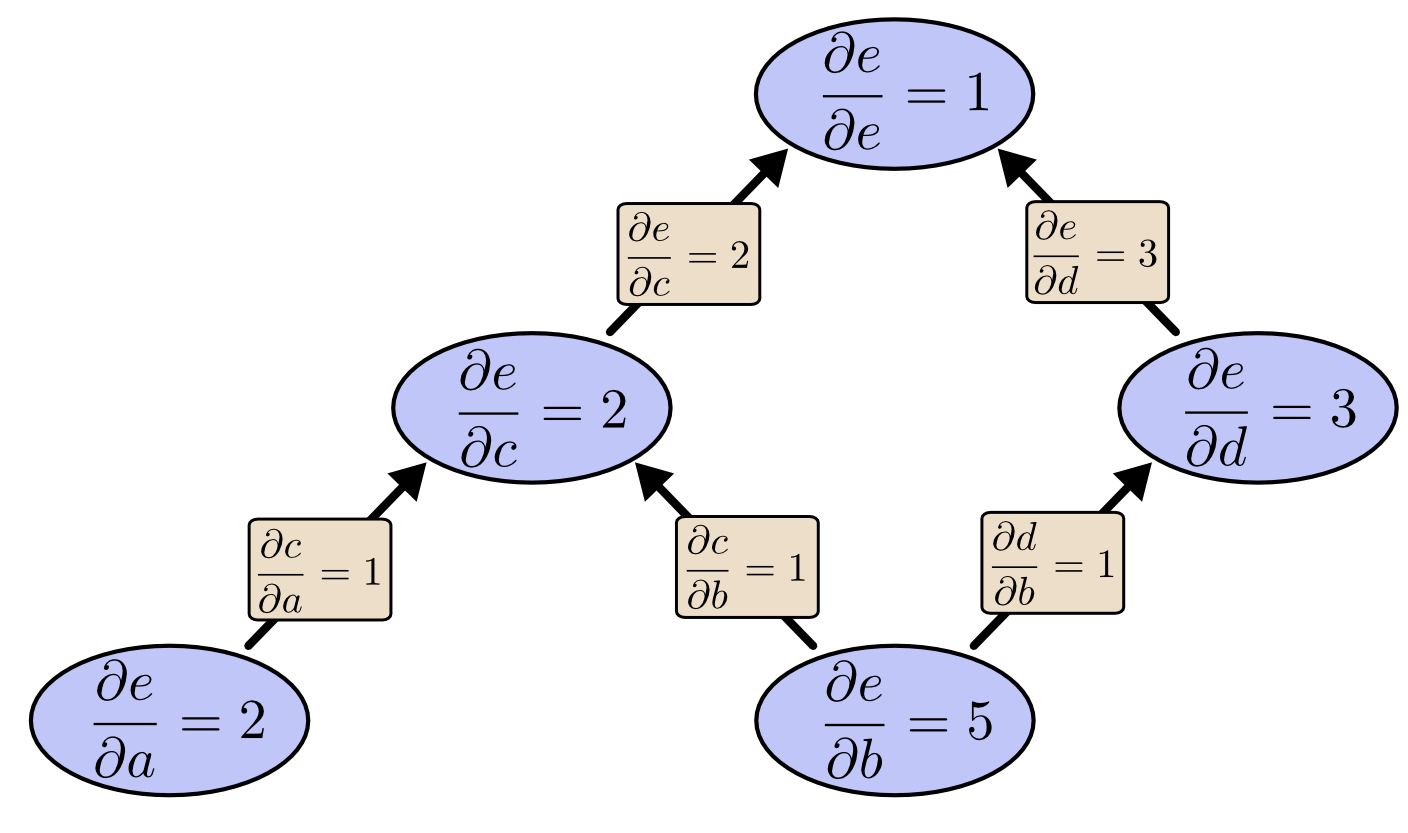

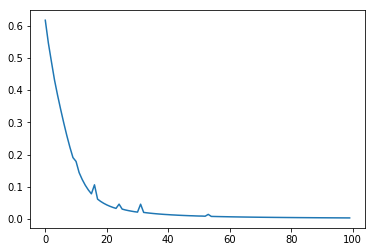

In [3]:
# BP算法
# 说明：x1,x2,x3为x的三个属性值，y1,y2为目标结果数据，w,v,u为3个初始权重矩阵

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

a = pd.DataFrame(np.random.randint(100,size=(3,100))) # 创建临时数据用于表示x的三个属性值x1,x2,x3
b = pd.DataFrame(np.random.randint(1000,size=(2,100)),index=list('34')) # 同样，创建y的两个结果数据y1,y2
s = 1/(1+np.exp(-b)) # 将结果数据sigmod处理输出
data = pd.concat([a,s]) # 整合成新矩阵

def BP_BACK(data,eta):
    w = np.random.rand(2,3)-0.5
    v = np.random.rand(3,2)-0.5
    u = np.random.rand(2,3)-0.5
    sigma = []
    for num in range(data.shape[1]):
        one_sample = data[num] # 取一组值
        x = one_sample[:3] # 提取输入数据
        y = one_sample[3:] # 提取输出数据
        net1 = w.dot(x) # 第一次求和值
        hidden1 = 1/(1+np.exp(-net1)) # 第一次sigmod处理输出
        net2 = v.dot(hidden1) # 第二次求和值
        hidden2 = 1/(1+np.exp(-net2)) # 第二次sigmod处理输出
        net3 = u.dot(hidden2) # 第三次求和值
        o = 1/(1+np.exp(-net3)) # 第三次sigmod处理输出最终值
        # 反向传播算法，计算各层delta值
        # 先从输出层开始，从右往左的顺序执行
        delta3 = (o-y).dot(o)*(1-o) # 输出层
        delta2 = hidden2.dot(1-hidden2)*delta3.dot(u) # 第二个隐层
        delta1 = hidden1.dot(1-hidden1)*delta2.dot(v) # 第一个隐层
        # 使用梯度下降算法迭代更新u,v,w
        for i in range(2):
            for j in range(3):
                u[i][j] = u[i][j] - eta*delta3[i]*hidden2[j] # 更新u权值
        for i in range(3):
            for j in range(2):
                v[i][j] = v[i][j] - eta*delta2[i]*hidden1[j] # 更新v权值
        for i in range(2):
            for j in range(3):
                w[i][j] = w[i][j] - eta*delta1[i]*x[i] # 更新w权值
        e = o - y # 计算误差向量
        sigma.append(e.dot(e)) # 计算误差平方和
    plt.plot(sigma)
    plt.show()

BP_BACK(data,0.8)

# 说明：图像是随着迭代次数的增加，误差越来越小，以至于趋近于0

In [10]:
# matlab中有关激活函数的说明：
# https://ww2.mathworks.cn/help/nnet/ug/multilayer-neural-network-architecture.html?s_tid=gn_loc_drop#bss33y1-2
# https://ww2.mathworks.cn/help/nnet/ug/train-and-apply-multilayer-neural-networks.html?searchHighlight=train%20and%20apply&s_tid=doc_srchtitle
# sklearn中多层分类器模型：from sklearn.neural_network import MLPClassifier

In [11]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

* MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
* 常见参数：
    * 参数activation：可选择激活函数，有{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}，默认‘relu’
    * 参数solver：优化方法，有{‘lbfgs’, ‘sgd’, ‘adam’}，默认‘adam’ 大数据量速度很快